In [3]:
import numpy as np
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sqlalchemy import create_engine
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture as GMM

import warnings
warnings.filterwarnings('ignore')

In [4]:
NBA = pd.read_csv('https://raw.githubusercontent.com/benvictoria17/DataAnalytics/main/dataset/NBA%20Players%20Stats%20-%202014-2015/players_stats.csv')

In [5]:
NBAc = NBA[pd.notnull(NBA['BMI'])]

In [6]:
print(NBA.columns)

Index(['Name', 'Games Played', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'Age', 'Birth_Place',
       'Birthdate', 'Collage', 'Experience', 'Height', 'Pos', 'Team', 'Weight',
       'BMI'],
      dtype='object')


In [7]:
duplicateRowsDF = NBA[NBA.duplicated()]
duplicateRowsDF

,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI


In [8]:
LAL_PLAYER = NBA.loc[NBA['Team']=='LAL']

LAL_PLAYER = LAL_PLAYER[['Name', 'Team', 'MIN', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']]

LAL_PLAYER.index = range(LAL_PLAYER.shape[0])

t_min, t_pts, t_reb, t_ast, t_stl, t_blk, t_tov =  LAL_PLAYER[['MIN', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']].sum()

attr_list = []

for i in LAL_PLAYER.index:
    
    p_name, p_team, p_min, p_pts, p_reb, p_ast, p_stl, p_blk, p_tov = LAL_PLAYER.iloc[i]
    
    attr_list.append([p_name, 'MIN', p_min/t_min])
    attr_list.append([p_name, 'PTS', p_pts/t_pts])
    attr_list.append([p_name, 'REB', p_reb/t_reb])
    attr_list.append([p_name, 'AST', p_ast/t_ast])
    attr_list.append([p_name, 'STL', p_stl/t_stl])
    attr_list.append([p_name, 'BLK', p_blk/t_blk])
    attr_list.append([p_name, 'TOV', p_tov/t_tov])
    
LAL_DATA = pd.DataFrame(attr_list, columns=['Name', 'Contribute_name', 'Values'])
import altair as alt

bars = alt.Chart(LAL_DATA).mark_bar().encode(
    x=alt.X('sum(Values)', stack='zero'),
    y=alt.Y('Contribute_name'),
    color=alt.Color('Name')
)

text = alt.Chart(LAL_DATA).mark_text(dx=-15, dy=3, color='white').encode(
    x=alt.X('sum(Values):Q', stack='zero'),
    y=alt.Y('Contribute_name'),
    detail='Name',
    text=alt.Text('sum(Values):Q', format='.4f')
)

(bars + text).properties(width=800, height=300)

alt.LayerChart(...)

In [9]:
NBA.head(10)

,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
0,AJ Price,26,324,133,51,137,37.2,15,57,26.3,...,29.0,us,"October 7, 1986",University of Connecticut,5,185.0,PG,PHO,81.45,23.798393
1,Aaron Brooks,82,1885,954,344,817,42.1,121,313,38.7,...,30.0,us,"January 14, 1985",University of Oregon,6,180.0,PG,CHI,72.45,22.361111
2,Aaron Gordon,47,797,243,93,208,44.7,13,48,27.1,...,20.0,us,"September 16, 1995",University of Arizona,R,202.5,PF,ORL,99.00,24.142661
3,Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,...,24.0,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.377751
4,Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,...,29.0,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.234384
5,Al Jefferson,65,1992,1082,486,1010,48.1,2,5,40.0,...,30.0,us,"January 4, 1985",NaN,10,205.0,C,CHA,130.05,30.945866
6,Alan Anderson,74,1744,545,195,440,44.3,73,210,34.8,...,33.0,us,"October 16, 1982",Michigan State University,5,195.0,SG,NJN,99.00,26.035503
7,Alec Burks,27,899,374,121,300,40.3,26,68,38.2,...,24.0,us,"July 20, 1991",University of Colorado,3,195.0,SG,UTA,96.30,25.325444
8,Alex Kirk,5,14,4,1,4,25.0,0,0,0.0,...,24.0,us,"November 14, 1991",University of New Mexico,R,210.0,C,CLE,110.25,25.000000
9,Alex Len,69,1518,432,179,353,50.7,1,3,33.3,...,22.0,ua,"June 16, 1993",University of Maryland,1,212.5,C,PHO,117.00,25.910035


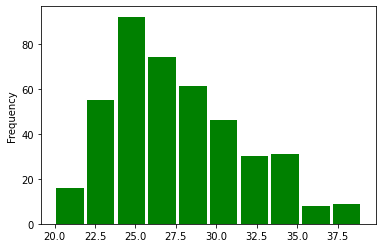

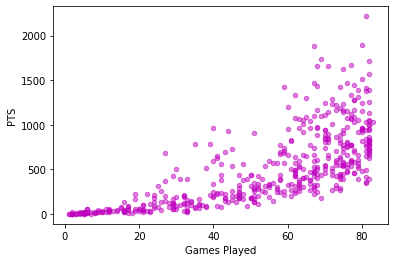

In [10]:
NBA.Age.plot.hist(rwidth=0.90,color= "g");

NBA.plot.scatter("Games Played", "PTS", alpha=0.5, color= "m");

In [11]:
height_weight_info = NBA[['Name', 'Height', 'Weight', 'Pos']]

height_weight_info.head(10)

,Name,Height,Weight,Pos
0,AJ Price,185.0,81.45,PG
1,Aaron Brooks,180.0,72.45,PG
2,Aaron Gordon,202.5,99.00,PF
3,Adreian Payne,205.0,106.65,PF
4,Al Horford,205.0,110.25,C
5,Al Jefferson,205.0,130.05,C
6,Alan Anderson,195.0,99.00,SG
7,Alec Burks,195.0,96.30,SG
8,Alex Kirk,210.0,110.25,C
9,Alex Len,212.5,117.00,C


In [12]:
three_points_rate = NBA[['Team', '3P%']]

team_three_points_rate = three_points_rate.groupby('Team').mean()

team_three_points_rate['Team']  = team_three_points_rate.index

team_three_points_rate.index = [i for i in range(30)]

team_three_points_rate.head(10)

,3P%,Team
0,32.080000,ATL
1,27.737500,BOS
2,25.914286,CHA
3,25.750000,CHI
4,28.458333,CLE
5,26.293333,DAL
6,26.781818,DEN
7,22.690909,DET
8,22.293333,GSW
9,27.745455,HOU


In [14]:
team_data = alt.Chart(team_three_points_rate).mark_bar(
    color='lightblue'
).encode(
    x = 'Team',
    y = '3P%'
)
mean_rate = alt.Chart(team_three_points_rate).mark_rule(
    color='green'
).encode(
    y = 'mean(3P%)'
)
(team_data + mean_rate).properties(width=600)

alt.LayerChart(...)

In [15]:
three_points_rate = NBA[['Team', '3PA']]

team_three_points_rate = three_points_rate.groupby('Team').mean()

team_three_points_rate['Team']  = team_three_points_rate.index

team_three_points_rate.index = [i for i in range(30)]

team_three_points_rate.head(10)

,3PA,Team
0,143.066667,ATL
1,178.875000,BOS
2,111.857143,CHA
3,130.357143,CHI
4,141.166667,CLE
5,147.600000,DAL
6,133.000000,DEN
7,123.181818,DET
8,155.733333,GSW
9,161.636364,HOU


In [16]:
team_data = alt.Chart(team_three_points_rate).mark_bar(
    color='lightgreen'
).encode(
    x = 'Team',
    y = '3PA'
)
mean_rate = alt.Chart(team_three_points_rate).mark_rule(
    color='red'
).encode(
    y = 'mean(3PA)'
)
(team_data + mean_rate).properties(width=600)
three_points_rate = NBA[['Team', '3PM']]

team_three_points_rate = three_points_rate.groupby('Team').mean()

team_three_points_rate['Team']  = team_three_points_rate.index

team_three_points_rate.index = [i for i in range(30)]

team_three_points_rate.head(10)

,3PM,Team
0,54.266667,ATL
1,60.250000,BOS
2,35.714286,CHA
3,46.071429,CHI
4,52.583333,CLE
5,50.400000,DAL
6,43.272727,DEN
7,42.454545,DET
8,61.066667,GSW
9,56.909091,HOU


In [17]:
team_data = alt.Chart(team_three_points_rate).mark_bar(
    color='lightyellow'
).encode(
    x = 'Team',
    y = '3PM'
)
mean_rate = alt.Chart(team_three_points_rate).mark_rule(
    color='red'
).encode(
    y = 'mean(3PM)'
)
(team_data + mean_rate).properties(width=600)


PTS_points_rate = NBA[['Team', 'PTS']]

team_PTS_points_rate = PTS_points_rate.groupby('Team').mean()

team_PTS_points_rate['Team']  = team_PTS_points_rate.index

team_PTS_points_rate.index = [i for i in range(30)]

team_PTS_points_rate.head(5)

,PTS,Team
0,572.733333,ATL
1,648.500000,BOS
2,518.428571,CHA
3,590.357143,CHI
4,544.000000,CLE


In [18]:
team_data = alt.Chart(team_PTS_points_rate).mark_bar(
    color='lightgreen'
).encode(
    x = 'Team',
    y = 'PTS'
)
mean_rate = alt.Chart(team_PTS_points_rate).mark_rule(
    color='red'
).encode(
    y = 'mean(PTS)'
)
(team_data + mean_rate).properties(width=600)

alt.LayerChart(...)

In [19]:
NBA.plot.scatter

<bound method PlotAccessor.scatter of <pandas.plotting._core.PlotAccessor object at 0x7fc4f9479dd0>>

Text(0, 0.5, 'Point')

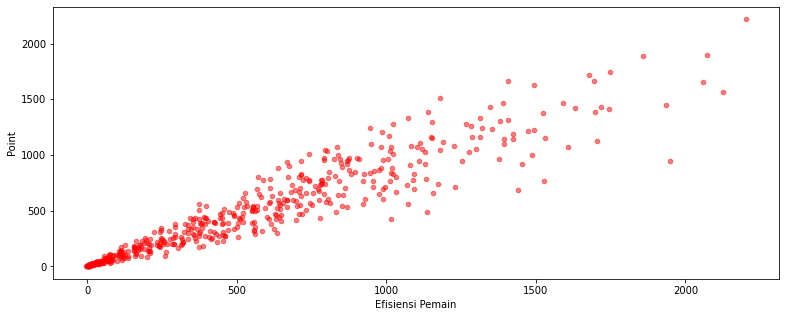

In [20]:
NBA.plot.scatter("EFF", "PTS", alpha=0.5, color= "r", figsize=(13,5))
plt.xlabel('Efisiensi Pemain')
plt.ylabel('Point')

In [23]:
Boston = NBA.Team == 'BOS'
Detroit = NBA.Team == 'DET'
Cleveland = NBA.Team == 'CLE'
Orlando = NBA.Team == 'ORL'
Toronto = NBA.Team == 'TOR'
Washington = NBA.Team == 'WAS'
Philadelphia = NBA.Team == 'PHI'
Milwaukee = NBA.Team == 'MIL'
NewYork = NBA.Team == 'NYK'
Atlanta = NBA.Team == 'ATL'
Charlote = NBA.Team == 'CHA'
Chicago = NBA.Team == 'CHI'
Indiana = NBA.Team == 'IND'
Miami = NBA.Team == 'MIA'

dfeast = NBA[Boston | Detroit | Cleveland | Orlando | Toronto | Washington | Philadelphia | 
            Milwaukee | NewYork | Atlanta | Charlote | Chicago | Indiana | Miami]
maxt = dfeast.groupby(['Team'])['PTS'].transform(max) == dfeast['PTS']
dfmax = dfeast[maxt]
dfmax.sort_values("EFF", ascending=False)

,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
372,Pau Gasol,78,2681,1446,570,1153,49.4,12,26,46.2,...,35.0,es,"July 6, 1980",NaN,13,210.0,PF,CHI,112.50,25.510204
301,LeBron James,69,2493,1743,624,1279,48.8,120,339,35.4,...,31.0,us,"December 30, 1984",NaN,11,200.0,SF,CLE,112.50,28.125000
359,Nikola Vucevic,74,2529,1428,631,1206,52.3,2,6,33.3,...,25.0,ch,"October 24, 1990",University of Southern California,3,210.0,C,ORL,117.00,26.530612
19,Andre Drummond,82,2502,1130,494,961,51.4,0,2,0.0,...,22.0,us,"August 10, 1993",University of Connecticut,2,207.5,C,DET,125.55,29.159530
315,Marcin Gortat,82,2453,1001,439,775,56.6,0,3,0.0,...,31.0,pl,"February 17, 1984",NaN,7,207.5,C,WAS,108.00,25.083466
374,Paul Millsap,73,2390,1218,443,930,47.6,77,216,35.6,...,30.0,us,"February 10, 1985",Louisiana Tech University,8,200.0,PF,ATL,110.70,27.675000
288,Kyle Lowry,70,2414,1244,430,1043,41.2,132,391,33.8,...,29.0,us,"March 25, 1986",Villanova University,8,182.5,PG,TOR,88.20,26.481516
5,Al Jefferson,65,1992,1082,486,1010,48.1,2,5,40.0,...,30.0,us,"January 4, 1985",NaN,10,205.0,C,CHA,130.05,30.945866
278,Khris Middleton,79,2378,1055,406,869,46.7,109,268,40.7,...,24.0,us,"August 12, 1991",Texas A&M University,2,200.0,SF,MIL,105.30,26.325000
311,Luol Deng,72,2421,1007,369,787,46.9,78,220,35.5,...,30.0,ss,"April 16, 1985",Duke University,10,202.5,SF,MIA,99.00,24.142661


In [24]:
import plotly.offline as py
import plotly.graph_objs as go

tr1 = go.Bar(
                 x = dfmax['Name'],
                 y = dfmax['EFF'],
                 name = 'Effisiensi',
                 marker = dict(color='crimson',
                              line = dict(color='rgba(0,0,0)', width=1)),
                 text = dfmax.Team)

tr2 = go.Bar(
                 x = dfmax['Name'],
                 y = dfmax['PTS'],
                 name = 'Points',
                 marker = dict(color='rgba(0, 1, 255, 1)',
                              line = dict(color='rgba(0,0,0)', width=1)),
                 text = dfmax.Team)
dn = [tr1, tr2]
layoutnew = go.Layout(barmode='group', title='Effisiensi Tertinggi Pemain pada TIM Regional Timur Terhadap Points')
fig = go.Figure(data=dn, layout=layoutnew)
fig.update_layout(barmode='stack')
py.iplot(fig)

In [25]:
engine= create_engine('sqlite:///:memory:')

dfeast.to_sql('data_table', engine) 
dfeastrt= pd.read_sql_query('SELECT SUM("EFF"), Team FROM data_table group by Team', engine)
K = dfeastrt['SUM("EFF")']
engine= create_engine('sqlite:///:memory:')

dfeast.to_sql('data_table', engine) 
dfeastrp= pd.read_sql_query('SELECT SUM("PTS"), Team FROM data_table group by Team', engine)
dfeastrp.insert(1, 'SEFF', K)
dfeastrp.rename(
    columns={
        'SUM("PTS")': "SPTS"
    },
    inplace=True)
dfeastrp['Rank'] = dfeastrp['SPTS'].rank(method='dense', ascending=False)
dfeastrp.sort_values("SPTS", ascending=False)

,SPTS,SEFF,Team,Rank
0,8591,10111,ATL,1.0
3,8265,9462,CHI,2.0
6,8160,9166,IND,3.0
12,7879,8483,TOR,4.0
10,7847,8614,ORL,5.0
2,7258,7992,CHA,6.0
9,7195,8017,NYK,7.0
13,6955,8080,WAS,8.0
4,6528,7214,CLE,9.0
8,6043,7080,MIL,10.0


In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfeastrp['Team'], y=dfeastrp['SEFF'], fill='tozeroy',name = 'Total Team Efficiency'))
fig.add_trace(go.Scatter(x=dfeastrp['Team'], y=dfeastrp['SPTS'], fill='tonexty',name = 'Number of Team Points'))

fig.show()

In [27]:
engine= create_engine('sqlite:///:memory:')

dfeast.to_sql('data_table', engine) 
gp= pd.read_sql_query('SELECT "Games Played" FROM data_table group by Team', engine)
dfeastrp.insert(3, 'GP', gp)

In [28]:
dfeastgpp = dfeastrp["SPTS"] / 82
dfeastgpp

0     104.768293
1      63.268293
2      88.512195
3     100.792683
4      79.609756
5      71.219512
6      99.512195
7      52.756098
8      73.695122
9      87.743902
10     95.695122
11     66.219512
12     96.085366
13     84.817073
Name: SPTS, dtype: float64

In [29]:
fig = {
        'data': [ 
             {
                'values' : dfeastgpp,
                'labels' : dfeastrp['Rank'],
                'domain' : {'x': [0, 1]},
                'name' : 'Points / Game',
                'hoverinfo' : 'label+percent+name',
                'hole' : 0.3,
                'type' : 'pie'
              },
             ],
         'layout' : {
                     'title' : 'คะแนนเฉลี่ยต่อเกมที่ได้รับจากทีมตามการจัดอันดับ',
                     'annotations' : [
                                        { 'font' : {'size' : 20},
                                          'showarrow' : False,
                                          'text' : ' ',
                                          'x' : 0.20,
                                          'y' : 1
                                         },
                                      ]    
                     }
        }
py.iplot(fig)
dfatl = dfeast[dfeast['Team'] == "ATL"]
dfatl

,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
3,Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,...,24.0,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.377751
4,Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,...,29.0,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.234384
110,DeMarre Carroll,70,2189,883,318,653,48.7,120,304,39.5,...,29.0,us,"July 27, 1986",University of Missouri,5,200.0,SF,ATL,96.75,24.187500
111,Dennis Schroder,77,1516,768,284,665,42.7,52,148,35.1,...,22.0,de,"September 15, 1993",NaN,1,182.5,PG,ATL,77.40,23.238882
139,Elton Brand,36,486,96,42,95,44.2,0,1,0.0,...,36.0,us,"March 11, 1979",Duke University,15,200.0,C,ATL,123.75,30.937500
215,Jeff Teague,73,2228,1162,408,887,46.0,71,207,34.3,...,27.0,us,"June 10, 1988",Wake Forest University,5,185.0,PG,ATL,83.70,24.455807
240,John Jenkins,24,297,135,49,99,49.5,21,52,40.4,...,24.0,us,"March 6, 1991",Vanderbilt University,2,190.0,SG,ATL,96.75,26.800554
270,Kent Bazemore,75,1324,390,141,331,42.6,48,132,36.4,...,26.0,us,"July 1, 1989",Old Dominion University,2,192.5,SG,ATL,90.45,24.408838
287,Kyle Korver,75,2418,911,292,600,48.7,221,449,49.2,...,34.0,us,"March 17, 1981",Creighton University,11,197.5,SG,ATL,95.40,24.457619
338,Mike Muscala,40,502,197,83,151,55.0,9,22,40.9,...,24.0,us,"July 1, 1991",Bucknell University,1,207.5,PF,ATL,108.00,25.083466


Text(0, 0.5, 'TRB/MIN')

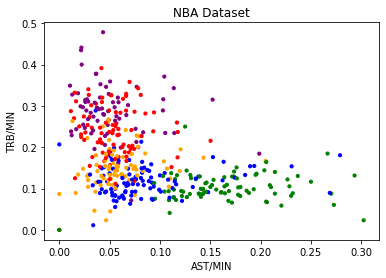

In [31]:
NBAdel1 =NBAc.Name != 'Sim Bhullar'
NBAdel2 = NBAc.Name != 'Jerrelle Benimon'
NBAcl = NBAc[NBAdel1 & NBAdel2]
NBAcl["TRB/MIN"] = NBAcl["REB"]/NBAcl["MIN"] 
NBAcl["AST/MIN"] = NBAcl["AST"]/NBAcl["MIN"]

fig, ax = plt.subplots()

x_var="AST/MIN"
y_var="TRB/MIN"

colors = {'SG':'blue', 'PF':'red', 'PG':'green', 'C':'purple', 'SF':'orange'}

ax.scatter(NBAcl[x_var], NBAcl[y_var], c=NBAcl['Pos'].apply(lambda x: colors[x]), s = 10)

ax.set_title('NBA Dataset')
ax.set_xlabel(x_var)
ax.set_ylabel(y_var)

In [32]:
NBAn = NBAcl[["AST/MIN","TRB/MIN"]]

kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(NBAn)
print(kmeans.cluster_centers_)

[[0.05603077 0.11447639]
 [0.04756151 0.31449755]
 [0.12794843 0.10667984]
 [0.2120548  0.11787054]
 [0.05672672 0.21286198]]


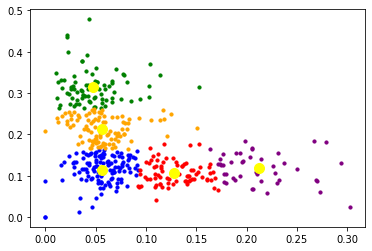

In [34]:
d1=NBAn[y_kmeans == 1]
d2=NBAn[y_kmeans == 2]
d3=NBAn[y_kmeans == 3]
d4=NBAn[y_kmeans == 4]

plt.scatter(d0[x_var], d0[y_var], s = 10, c = 'blue', label = 'D0')
plt.scatter(d1[x_var], d1[y_var], s = 10, c = 'green', label = 'D1')
plt.scatter(d2[x_var], d2[y_var], s = 10, c = 'red', label = 'D2')
plt.scatter(d3[x_var], d3[y_var], s = 10, c = 'purple', label = 'D3')
plt.scatter(d4[x_var], d4[y_var], s = 10, c = 'orange', label = 'D4')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')

In [35]:
d0[x_var]='SG'
d1[x_var]='PF'
d2[x_var]='PG'
d3[x_var]='C'
d4[x_var]='SF'

NBAlist = pd.concat([d0[x_var], d1[x_var], d2[x_var], d3[x_var], d4[x_var]])
NBAcluster = (NBAc[["Name", "Team", "Pos"]])
NBAcluster

NBAcl["TRB/MIN"]
NBAcl["AST/MIN"]

NBAcluster.insert(2, 'TRBMIN', NBAcl["TRB/MIN"])
NBAcluster.insert(3, 'ASTMIN', NBAcl["AST/MIN"])
NBAcluster.insert(5, 'Next Pos', NBAlist)
NBAcluster

,Name,Team,TRBMIN,ASTMIN,Pos,Next Pos
0,AJ Price,PHO,0.098765,0.141975,PG,PG
1,Aaron Brooks,CHI,0.088064,0.138462,PG,PG
2,Aaron Gordon,ORL,0.212045,0.041405,PF,SF
3,Adreian Payne,ATL,0.218919,0.040541,PF,SF
4,Al Horford,ATL,0.234685,0.105263,C,SF
...,...,...,...,...,...,...
485,Xavier Henry,LAL,0.046512,0.034884,SF,SG
486,Zach LaVine,MIN,0.112513,0.145110,PG,PG
487,Zach Randolph,MEM,0.324219,0.066406,PF,PF
488,Zaza Pachulia,MIL,0.289017,0.102890,C,PF
